In [4]:
import os
import shutil
import random
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

In [5]:
DATASET_PATH = "/kaggle/input/lung-cancer-histopathological-images"

In [6]:
WORKING_DIR = "/kaggle/working/dataset"
if not os.path.exists(WORKING_DIR):
    shutil.copytree(DATASET_PATH, WORKING_DIR)

In [7]:
classes = ["adenocarcinoma", "benign", "squamous_cell_carcinoma"]

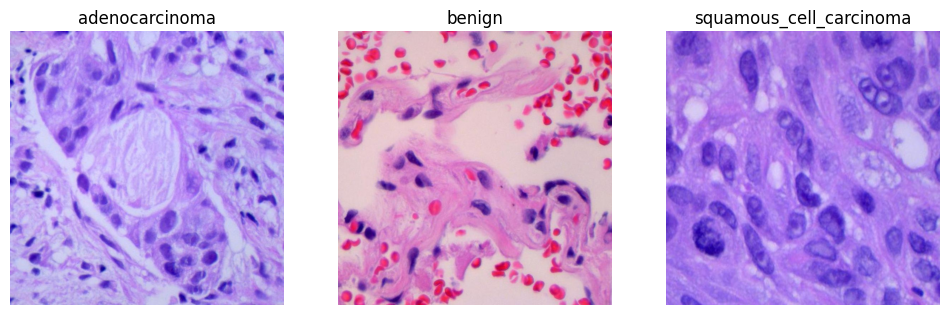

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, label in enumerate(classes):
    img_path = os.path.join(WORKING_DIR, label)
    img_file = random.choice(os.listdir(img_path))
    img = cv2.imread(os.path.join(img_path, img_file))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axes[i].imshow(img)
    axes[i].set_title(label)
    axes[i].axis("off")
plt.show()


In [9]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 64

# Create ImageDataGenerator with augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Load training data
train_data = datagen.flow_from_directory(
    WORKING_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training'
)

# Load validation data
val_data = datagen.flow_from_directory(
    WORKING_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation'
)

Found 12000 images belonging to 3 classes.
Found 3000 images belonging to 3 classes.


In [10]:
from tensorflow.keras.regularizers import l2
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model layers
base_model.trainable = False

# Build model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128,activation='relu', kernel_regularizer=l2(1e-5)),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# EarlyStopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,  
    patience=3,  
    min_lr=1e-6
)
# Train model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


188/188 ━━━━━━━━━━━━━━━━━━━━ 220s 1s/step - accuracy: 0.6923 - loss: 0.6768 - val_accuracy: 0.9213 - val_loss: 0.2049 - learning_rate: 1.0000e-04
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 192s 991ms/step - accuracy: 0.9254 - loss: 0.1974 - val_accuracy: 0.9337 - val_loss: 0.1728 - learning_rate: 1.0000e-04
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 191s 987ms/step - accuracy: 0.9354 - loss: 0.1689 - val_accuracy: 0.9347 - val_loss: 0.1583 - learning_rate: 1.0000e-04
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 192s 990ms/step - accuracy: 0.9375 - loss: 0.1598 - val_accuracy: 0.9410 - val_loss: 0.1431 - learning_rate: 1.0000e-04
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 194s 1000ms/step - accuracy: 0.9442 - loss: 0.1497 - val_accuracy: 0.9460 - val_loss: 0.1374 - learning_rate: 1.0000e-04
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 191s 989ms/step - accuracy: 0.9416 - loss: 0.1485 - val_accuracy: 0.9493 - val_loss: 0.1295 - learning_rate: 1.0000e-04
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 192s 990ms/st

In [11]:
import matplotlib.pyplot as plt

# Extract accuracy and loss values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)



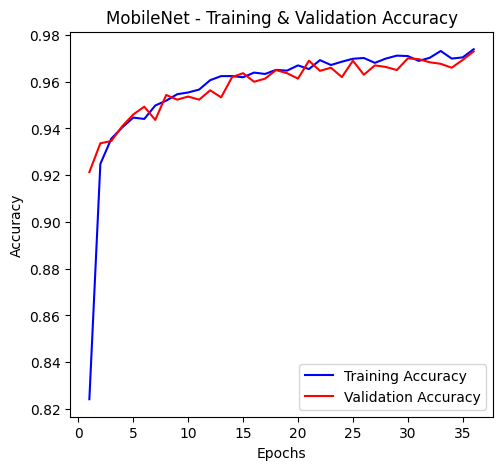

In [ ]:
# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('MobileNet - Training & Validation Accuracy')
plt.legend()



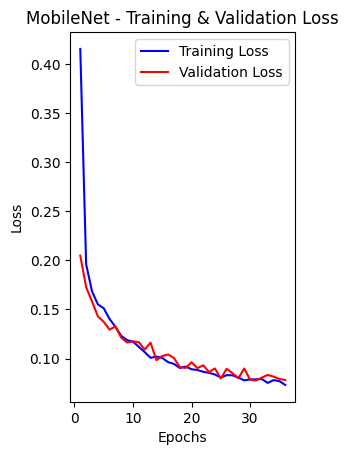

In [ ]:
# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MobileNet - Training & Validation Loss')
plt.legend()

plt.show()


In [ ]:
# Save the entire model (architecture + weights)
model.save("mobilenet_lung_cancer.h5")
print("MobileNet model saved.")

MobileNet model saved.


In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224 (Functional)    │ (None, 7, 7, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,751,051 (10.49 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 328,712 (1.25 MB)

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

# Load pre-trained EfficientNetB1 model
base_model = tf.keras.applications.EfficientNetV2B1(
    input_shape=(224, 224, 3),
    include_top=False,  # Remove the original classification head
    weights='imagenet'  # Load pre-trained weights
)

# 🔒 Freeze all layers initially
base_model.trainable = False  

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu', kernel_regularizer=l2(1e-5)),
    layers.Dropout(0.3),
    layers.Dense(3, activation='softmax')  # Adjust to your number of classes
])

# Compile model
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Print summary to check frozen layers
model.summary()


24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetv2-b0 (Functional)       │ (None, 7, 7, 1280)          │       5,919,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │         163,968 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,083,667 (23.21 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 5,919,312 (22.58 MB)

In [ ]:
# Early stopping & learning rate scheduler
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,  
    patience=3,  
    min_lr=1e-6
)

# Train model
history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,  # Start with a few epochs while frozen
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 240s 1s/step - accuracy: 0.3379 - loss: 1.1101 - val_accuracy: 0.3310 - val_loss: 1.1008 - learning_rate: 1.0000e-04
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 192s 993ms/step - accuracy: 0.3641 - loss: 1.0984 - val_accuracy: 0.3603 - val_loss: 1.0952 - learning_rate: 1.0000e-04
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 191s 987ms/step - accuracy: 0.3522 - loss: 1.0983 - val_accuracy: 0.4570 - val_loss: 1.0945 - learning_rate: 1.0000e-04
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 193s 995ms/step - accuracy: 0.3623 - loss: 1.0967 - val_accuracy: 0.3520 - val_loss: 1.0950 - learning_rate: 1.0000e-04
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.3697 - loss: 1.0959 - val_accuracy: 0.4040 - val_loss: 1.0929 - learning_rate: 1.0000e-04
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 193s 995ms/step - accuracy: 0.3715 - loss: 1.0955 - val_accuracy: 0.4467 - val_loss: 1.0920 - learning_rate: 1.0000e-04
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 191s 9

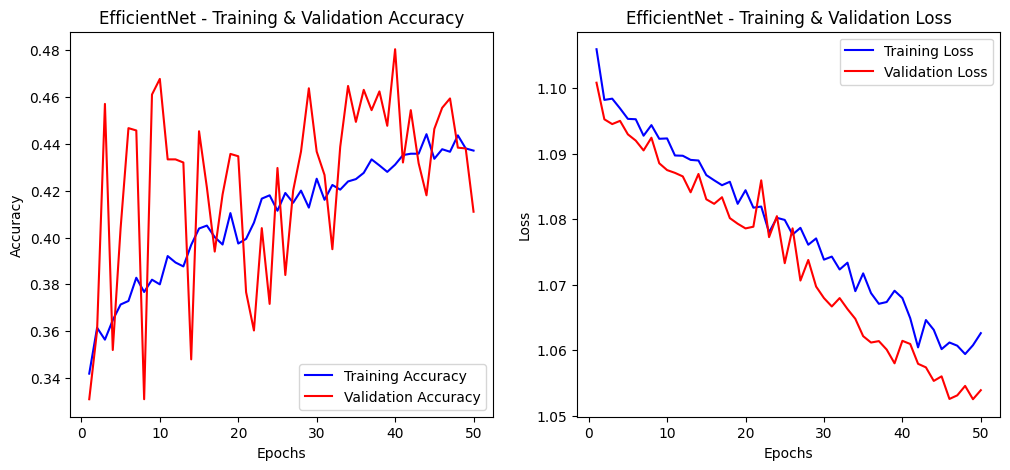

EfficientNet model saved.


In [ ]:
#import matplotlib.pyplot as plt

# Extract accuracy and loss values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('EfficientNet - Training & Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('EfficientNet - Training & Validation Loss')
plt.legend()

plt.show()

# Save the model
model.save("efficientnet_lung_cancer.h5")
print("EfficientNet model saved.")

In [ ]:
!pip install -q keras-squeezenet

  Preparing metadata (setup.py) ... done


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2

def fire_module(x, squeeze_filters, expand_filters):
    x = layers.Conv2D(squeeze_filters, (1, 1), activation='relu')(x)
    left = layers.Conv2D(expand_filters, (1, 1), activation='relu')(x)
    right = layers.Conv2D(expand_filters, (3, 3), padding='same', activation='relu')(x)
    x = layers.concatenate([left, right])
    return x

def build_squeezenet(input_shape=(224, 224, 3), num_classes=3):
    input_img = tf.keras.Input(shape=input_shape)
    
    x = layers.Conv2D(96, (7, 7), strides=(2, 2), padding='valid', activation='relu')(input_img)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 16, 64)
    x = fire_module(x, 16, 64)
    x = fire_module(x, 32, 128)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 32, 128)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 48, 192)
    x = fire_module(x, 64, 256)
    x = layers.MaxPooling2D(pool_size=(3, 3), strides=(2, 2))(x)

    x = fire_module(x, 64, 256)
    x = layers.Dropout(0.5)(x)
    x = layers.Conv2D(num_classes, (1, 1), activation='relu')(x)
    x = layers.GlobalAveragePooling2D()(x)
    output = layers.Activation('softmax')(x)

    model = models.Model(inputs=input_img, outputs=output)
    return model

# Build SqueezeNet
model = build_squeezenet()

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.AdamW(learning_rate=0.0001, weight_decay=1e-5),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 109, 109, 96)   │         14,208 │ input_layer_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_3           │ (None, 54, 54, 96)     │              0 │ conv2d_26[0][0]        │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 54, 54, 16)     │          1,552 │ max_pooling2d_3[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 54, 54, 64)     │          1,088 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 54, 54, 64)     │          9,280 │ conv2d_27[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 54, 54, 128)    │              0 │ conv2d_28[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_29[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_30 (Conv2D)        │ (None, 54, 54, 16)     │          2,064 │ concatenate_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_31 (Conv2D)        │ (None, 54, 54, 64)     │          1,088 │ conv2d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_32 (Conv2D)        │ (None, 54, 54, 64)     │          9,280 │ conv2d_30[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_9             │ (None, 54, 54, 128)    │              0 │ conv2d_31[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_32[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_33 (Conv2D)        │ (None, 54, 54, 32)     │          4,128 │ concatenate_9[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_34 (Conv2D)        │ (None, 54, 54, 128)    │          4,224 │ conv2d_33[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_35 (Conv2D)        │ (None, 54, 54, 128)    │         36,992 │ conv2d_33[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_10            │ (None, 54, 54, 256)    │              0 │ conv2d_34[0][0],       │
│ (Concatenate)             │                        │                │ conv2d_35[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_4           │ (None, 26, 26, 256)    │              0 │ concatenate_10[0][0]   │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)   

 Total params: 736,963 (2.81 MB)

 Trainable params: 736,963 (2.81 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=5,
    restore_best_weights=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.5,  
    patience=3,  
    min_lr=1e-6
)

history = model.fit(
    train_data,
    validation_data=val_data,
    epochs=50,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)


Epoch 1/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 232s 1s/step - accuracy: 0.6014 - loss: 0.8409 - val_accuracy: 0.7997 - val_loss: 0.4094 - learning_rate: 1.0000e-04
Epoch 2/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 194s 1s/step - accuracy: 0.8613 - loss: 0.3478 - val_accuracy: 0.8913 - val_loss: 0.2903 - learning_rate: 1.0000e-04
Epoch 3/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 191s 988ms/step - accuracy: 0.8749 - loss: 0.3024 - val_accuracy: 0.8933 - val_loss: 0.2763 - learning_rate: 1.0000e-04
Epoch 4/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 192s 995ms/step - accuracy: 0.8832 - loss: 0.2899 - val_accuracy: 0.8940 - val_loss: 0.2540 - learning_rate: 1.0000e-04
Epoch 5/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 192s 993ms/step - accuracy: 0.8816 - loss: 0.2828 - val_accuracy: 0.8730 - val_loss: 0.2772 - learning_rate: 1.0000e-04
Epoch 6/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 193s 997ms/step - accuracy: 0.8961 - loss: 0.2489 - val_accuracy: 0.9183 - val_loss: 0.2025 - learning_rate: 1.0000e-04
Epoch 7/50
188/188 ━━━━━━━━━━━━━━━━━━━━ 192s 9

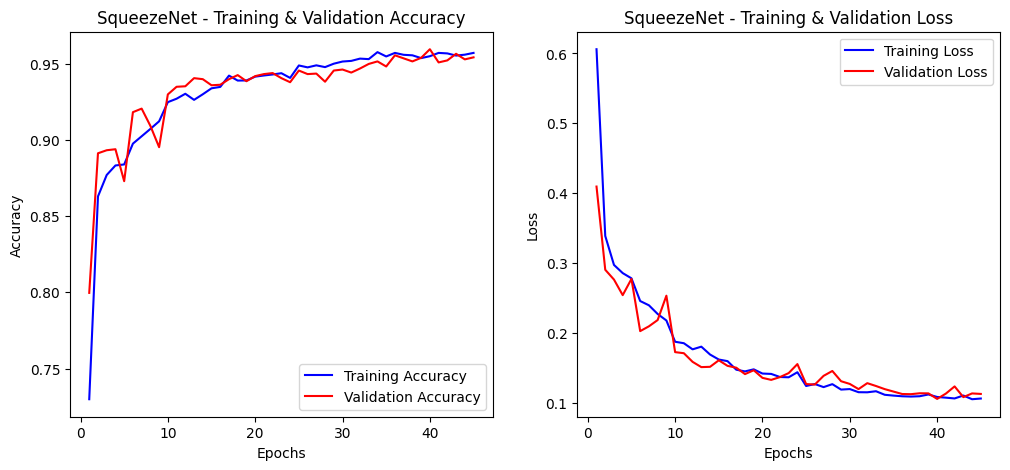

SqueezeNet model saved.


In [ ]:
#import matplotlib.pyplot as plt

# Extract accuracy and loss values
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(train_acc) + 1)

# Plot Accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_acc, 'b-', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('SqueezeNet - Training & Validation Accuracy')
plt.legend()

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(epochs, train_loss, 'b-', label='Training Loss')
plt.plot(epochs, val_loss, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('SqueezeNet - Training & Validation Loss')
plt.legend()

plt.show()

# Save model
model.save('/kaggle/working/squeezenet_lung_cancer.h5')
print("SqueezeNet model saved.")
